# Creating a monthly NEE dataset, using CarbonTracker model

This notebook outlines the workflow for creating a monthly NEE dataset. You first need to have run the CarbonTracker workflow to train and create the model. 

To create the dataset you need:

- CarbonTracker model
- ERA5 (monthly)
- ERA5-land (monthly)
- SPEI (monthly)
- MODIS (monthly)
- Biomass (yearly)
- Copernicus Landcover (yearly)


In [4]:
from pathlib import Path

import matplotlib.pyplot as plt
import xarray as xr
from dask.distributed import Client

import excited_workflow
from excited_workflow import produce_carbontracker_dataset
from excited_workflow.source_datasets import datasets


client = Client()

Define the paths needed for the carbon tracker dataset, regions dataset, model that contains the model and data directory.

In [5]:
home_path = Path.home()
input_dir = Path("/home/cdonnelly/carbon_tracker-2024-01-15_12_58")

data_dir = home_path / "data/volume_2"
cb_file= data_dir / "EXCITED_prepped_data/CT2022.flux1x1-monthly.nc"
regions_file = data_dir / "EXCITED_prepped_data/regions.nc"

onnx_model = input_dir / "lightgbm.onnx"
variables_file = input_dir / "model_variables.txt"

Read x_keys, y_key and desired datasets from model_variables.txt file.

In [6]:
model_vars = []
with open(variables_file, 'r') as f:
    for line in f:
        model_vars.append(eval(line))

x_keys = model_vars[0]
y_key = model_vars[1]
desired_data = model_vars[2]

print(x_keys)

['d2m', 'mslhf', 'msshf', 'ssr', 'str', 't2m', 'spei', 'NIRv', 'skt', 'stl1', 'swvl1', 'lccs_class']


Merge the desired datasets into a single xr.Dataset with the same dimensions as the carbon tracker dataset. 

In [7]:
ds_cb = xr.open_dataset(cb_file)
ds_cb = excited_workflow.utils.convert_timestamps(ds_cb)
ds_regions = xr.open_dataset(regions_file)
ds_input = xr.merge(
    [
        datasets[name].load(freq="monthly", target_grid=ds_cb)
        for name in desired_data
    ]
)

Run prediction model for each month where all data is available.

In [8]:
dfs = produce_carbontracker_dataset.get_predictions(ds_input, x_keys, ds_regions, 
                                                         onnx_model)

Create a NEE dataset with all prediction arrays and save as a netcdf. 

In [9]:
ds_out = produce_carbontracker_dataset.create_dataset(dfs, data_dir, x_keys)

Plot NEE and original Carbon Tracker data to look at differences and check everything worked correctly. 

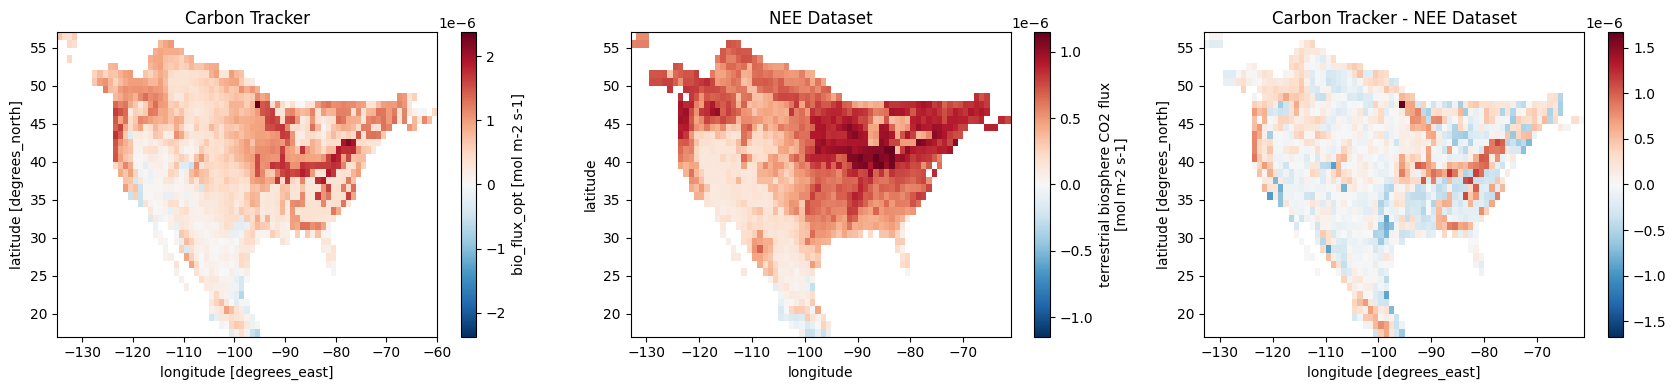

In [10]:
ds_merge = xr.merge([ds_cb, ds_regions["transcom_regions"]])
ds_na = ds_merge.where(ds_merge["transcom_regions"] == 2)
time_region_na = {
    "time": "2019-11-01",
    "latitude": slice(17, 57),
    "longitude": slice(-135, -60),
}

diff = ds_na["bio_flux_opt"] - ds_out["bio_flux"]

fig, axs = plt.subplots(1,3, figsize = (17, 4))
ds_na["bio_flux_opt"].sel(time_region_na).plot(ax=axs[0])
axs[0].set_title("Carbon Tracker")
ds_out["bio_flux"].sel(time_region_na).plot(ax=axs[1])
axs[1].set_title("NEE Dataset")
diff.sel(time_region_na).plot(ax=axs[2])
axs[2].set_title("Carbon Tracker - NEE Dataset")
plt.tight_layout()